In [1]:
from typing import Literal, TypeAlias
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

In [2]:
random_state = 13

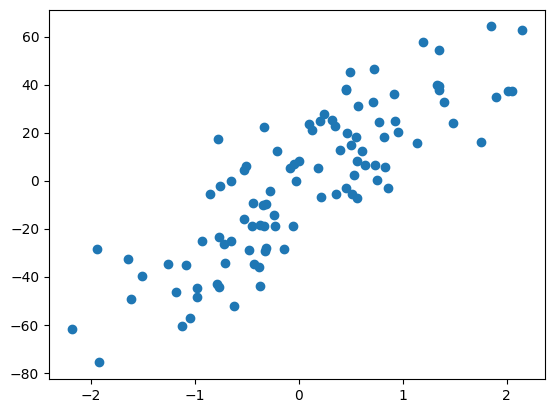

In [3]:
X, y, *_ = make_regression(
    n_samples=100, n_features=1, n_informative=1, n_targets=1, noise=20, random_state=random_state
)
plt.scatter(X, y)
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print(f"{lr.coef_ = }\n{lr.intercept_ = }")

lr.coef_ = array([28.67684216])
lr.intercept_ = -2.0886997661341002


In [6]:
y_pred = lr.predict(X_test)

In [7]:
def score(y_true, y_pred) -> None:
    print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
    print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
    print("R2 Score:", r2_score(y_true, y_pred))

In [8]:
score(y_test, y_pred)

Mean Absolute Error: 12.403644268889787
Mean Squared Error: 214.83289105384182
R2 Score: 0.7133770366708299


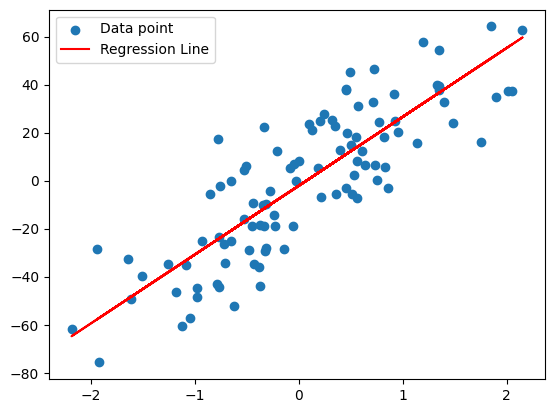

In [9]:
plt.scatter(X, y, label="Data point")
plt.plot(X, lr.predict(X), color="red", label="Regression Line")

plt.legend()
plt.show()


---

## My Gradient Descent class

In [10]:
def loss_func(X, y, m, b):
    return np.sum((y - ((m * X) + b)) ** 2)

In [11]:
@dataclass
class GDRegressor:
    learning_rate: float = 0.001
    epochs: int = 30

    def __post_init__(self) -> None:
        self._m = 0
        self._b = 1

        self.all_m = []
        self.all_b = []
        self.all_cost = []

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        for i in range(self.epochs):
            cost = loss_func(X_train, y_train, self._m, self._b)

            if len(self.all_cost) > 1:
                if self.all_cost[-1] - self.all_cost[-2] < 0.001:
                    print(f"Model takes only {i} epochs to achieve good cost.")
                    break

            loss_slope_b = -2 * np.sum(y_train - self._m * X_train.ravel() - self._b)
            loss_slope_m = -2 * np.sum(
                (y_train - self._m * X_train.ravel() - self._b) * X_train.ravel()
            )

            self.all_cost.append(cost)

            self._m -= loss_slope_m * self.learning_rate
            self.all_m.append(self._m)

            self._b -= loss_slope_b * self.learning_rate
            self.all_b.append(self._b)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self._m * X + self._b

    @property
    def coef_(self):
        return self._m

    @property
    def intercept_(self):
        return self._b

In [12]:
# I keep (epochs<25) for repersentation, you can increase it for better result
gd = GDRegressor(0.001, 10)
gd.fit(X_train, y_train)

print(gd.coef_, gd.intercept_)

21.525593541579337 -2.1608639303458794


In [13]:
y_pred_gd = gd.predict(X_test)
score(y_test, y_pred_gd)

Mean Absolute Error: 12.298540197697223
Mean Squared Error: 219.12666059076165
R2 Score: 0.7076484308577841


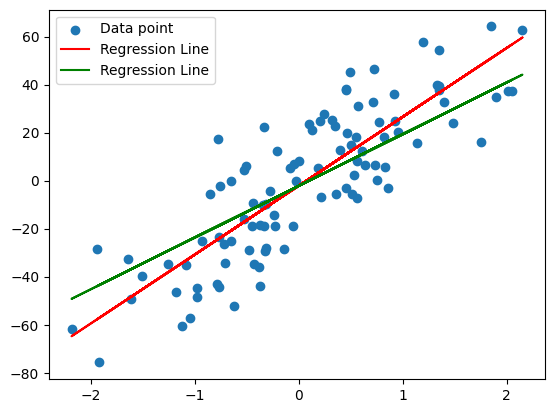

In [14]:
plt.scatter(X, y, label="Data point")
plt.plot(X, lr.predict(X), color="red", label="Regression Line")
plt.plot(X, gd.predict(X), color="green", label="Regression Line")

plt.legend()
plt.show()


---

# Animation with Matplotlib

In [15]:
ChangeInGraphType: TypeAlias = Literal["intercept", "slope", "cost"]

In [16]:
@dataclass
class AnimateRegressor:
    X: np.ndarray
    y: np.ndarray
    learning_rate: float = 0.001
    epochs: int = 30
    m: float | np.floating = 100
    b: float | np.floating = -200

    def __post_init__(self):
        self._build_model()

        self.y_pred = self.m * self.X + self.b

    def _build_model(self):
        self.all_m = []
        self.all_b = []
        self.all_cost = []

        for _ in range(self.epochs):
            loss_slope_b = -2 * np.sum(y - self.m * X.ravel() - self.b)
            loss_slope_m = -2 * np.sum((y - self.m * X.ravel() - self.b) * X.ravel())

            cost = loss_func(self.X, self.y, self.m, self.b)
            self.all_cost.append(cost)

            self.m -= loss_slope_m * self.learning_rate
            self.all_m.append(self.m)

            self.b -= loss_slope_b * self.learning_rate
            self.all_b.append(self.b)

    def model_score(self):
        score(self.y, self.y_pred)

    def _save_animated(self, animated: FuncAnimation, save: Path) -> None:
        writergif = PillowWriter(fps=2)
        animated.save(save.as_posix(), writer=writergif)  # type: ignore

    def reg_line(self, save: Path | None = None):
        fig, ax = plt.subplots(figsize=(9, 5))
        fig.set_tight_layout(True)
        ax.set_title("Model training using Gradient Descent", fontsize=18)

        ax.scatter(self.X, self.y, label="Data Point")
        ax.plot(X, self.y_pred, c="green", label="Org Reg Line")
        ax.set_xlabel("X")
        ax.set_ylabel("y")

        x_i = np.arange(-2.2, 2.8, 0.5)
        line, *_ = ax.plot(x_i, x_i * 50 - 4, "r-", linewidth=2)

        def update_animation(i: int):
            line.set_ydata(x_i * self.all_m[i] + self.all_b[i])
            line.set_label(f"Regressor Line: Epoch({i+1})")
            ax.legend(loc="upper center")

        animated = FuncAnimation(
            fig=fig, func=update_animation, repeat=True, frames=self.epochs, interval=200
        )

        if save is not None:
            self._save_animated(animated, save)
        else:
            return animated

    def _animate_change_in_epoch_graph(self, graph_type: ChangeInGraphType, save: Path | None):
        if graph_type == "slope":
            all_list = self.all_m
        elif graph_type == "intercept":
            all_list = self.all_b
        elif graph_type == "cost":
            all_list = self.all_cost
        else:
            raise ValueError("Enter right value for param `graph_type`.")

        fig = plt.figure(figsize=(9, 5))
        ax = plt.axes(xlim=(0, self.epochs), ylim=(0, all_list[0]))
        ax.set_title(f"Change in {graph_type.title()} (w.r.t epochs)", fontsize=18)

        xdata, ydata = [], []
        line, *_ = ax.plot(xdata, ydata, linewidth=2)

        def update_animation(i: int):
            xdata.append(i)
            ydata.append(all_list[i])
            line.set_data(xdata, ydata)
            ax.scatter(i, all_list[i], marker="+", c="red")  # type: ignore

            line.set_label(f"Epoch({i+1})")
            ax.legend()

        animated = FuncAnimation(
            fig=fig, func=update_animation, repeat=True, frames=self.epochs, interval=200
        )

        if save:
            self._save_animated(animated, save)
        else:
            return animated

    def change_in_intercept(self, save: Path | None = None):
        return self._animate_change_in_epoch_graph("intercept", save)

    def change_in_slope(self, save: Path | None = None):
        return self._animate_change_in_epoch_graph("slope", save)

    def change_in_cost(self, save: Path | None = None):
        return self._animate_change_in_epoch_graph("cost", save)

In [17]:
animate = AnimateRegressor(X, y)
animate.model_score()

Mean Absolute Error: 13.975578018078403
Mean Squared Error: 283.68125200427073
R2 Score: 0.7032478331640231


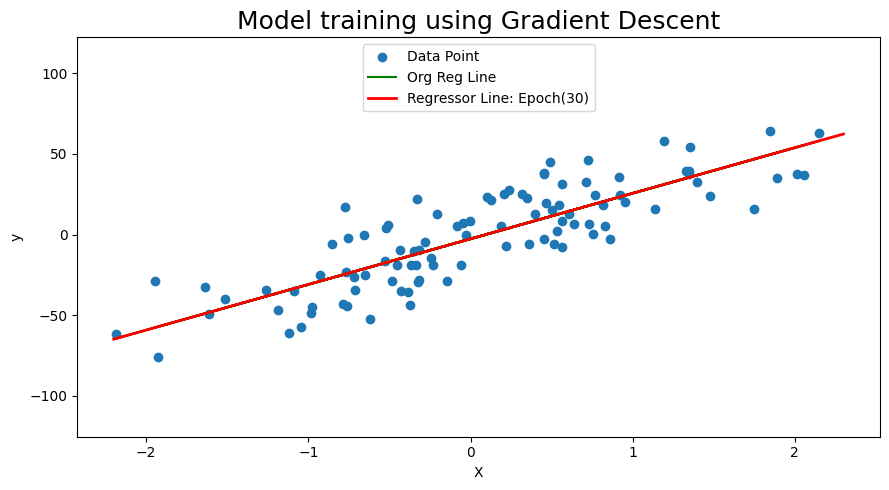

In [18]:
animate.reg_line(Path("./GD Regressor/img/training_with_gd.gif"))

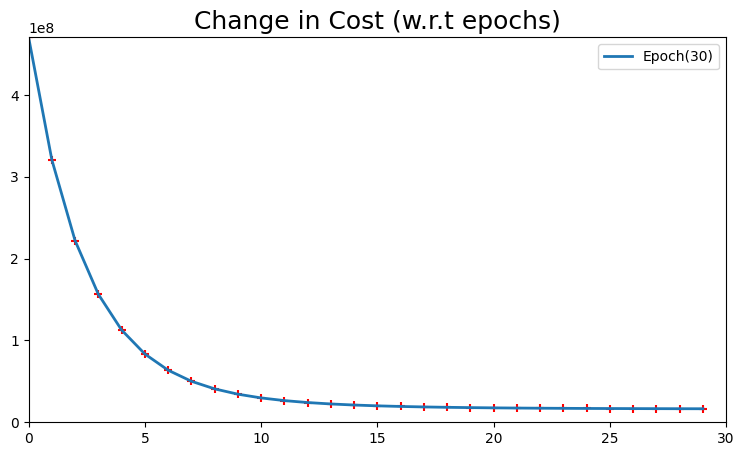

In [19]:
animate.change_in_cost(Path("./GD Regressor/img/change_in_cost.gif"))

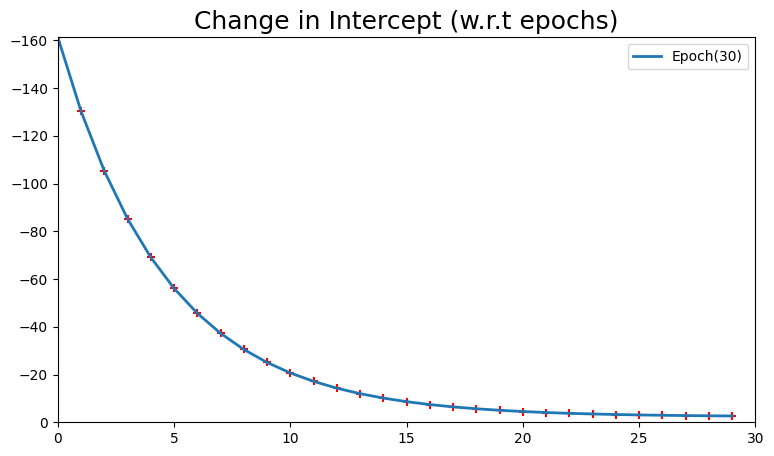

In [20]:
animate.change_in_intercept(Path("./GD Regressor/img/change_in_intercept.gif"))

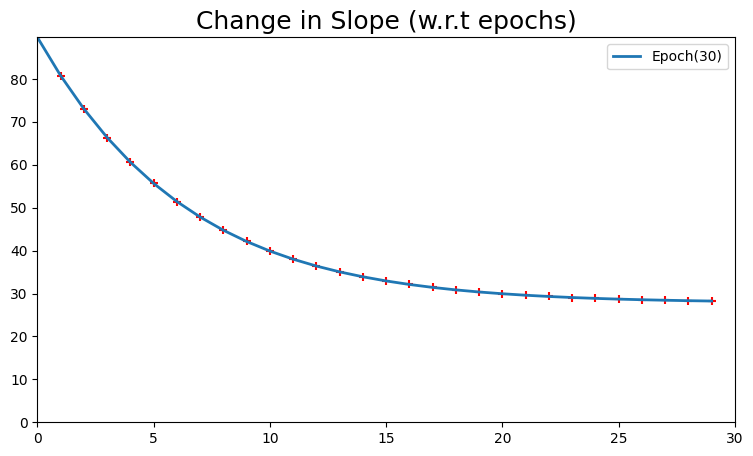

In [21]:
animate.change_in_slope(Path("./GD Regressor/img/change_in_slope.gif"))